# Introduction
Le programme SPICE (Simulated Program with Integrated Circuit Emphasis) effectue des simulations de circuits électroniques analogiques. La version de référence (spice 2g6, 1983) est écrite en fortran. Une version plus récente (spice 3, 1985) est écrite en C. De nombreux logiciels commerciaux de simulation utilisent le moteur de calcul de SPICE, en ajoutant des fonctions supplémentaires.

On s'intéresse ici aux versions libres de spice, ngspice et SpiceOpus, qui reposent sur spice3f5. Ces deux programmes lisent un fichier texte comportant une description du circuit et différentes commandes. La commande print permet d'exporter les résultats dans un fichier texte. La commande plot permet de tracer des courbes. Afin d'obtenir des sorties graphiques de haute qualité, ou d'effectuer différents traitements des données, il peut être utile d'importer dans Python les données exportées par SPICE avec la commande print. Cette page présente une fonction python faisant cette importation. 

# Fonction python d'importation

Pour exporter des données dans un fichier texte, la commande spice est : 

PRINT v1 v2 ... > fichier.txt, où v1 v2 ... sont les noms des vecteurs de données à exporter.

La fonction suivante effectue l'importation des données du fichier, qu'elle renvoit sous forme d'un dictionnaire dont les clés sont les noms des champs. Les tableaux numpy obtenus sont des tableaux de réels ou de complexes. 

In [ ]:
import re
import numpy 

def lectureSpicePrint(filename):
    f = open(filename,"r")
    lignes = f.readlines()
    k = 0
    while not re.match("-+",lignes[k]):
        print(lignes[k])
        k += 1
    k += 1
    entete =lignes[k].strip()
    champs = re.split("\s+",entete)
    print(champs)
    k += 2
    ligne = lignes[k].strip()
    valeurs = re.split("\s+",ligne)
    complexes = []
    data = {}
    j = 0
    for i in range(len(champs)):
        valeurs[i] = valeurs[i].strip()
        if valeurs[j][len(valeurs[j])-1] == ",":
            complexes.append(True)
            j += 2
            data[champs[i]] = numpy.zeros(0,numpy.complex128)
        else:
            complexes.append(False)
            j += 1
            data[champs[i]] = numpy.zeros(0,numpy.float64)
    index = 0
    while k < len(lignes):
        ligne = lignes[k].strip()
        if re.match("^[\d+]",ligne):
            valeurs = re.split("\s+",ligne)
            j = 0
            for i in range(len(champs)):
                if complexes[i]:
                    valeurs[j]= valeurs[j][:len(valeurs[2])-1]
                    valeurs[j]= valeurs[j].replace(",",".")
                    valeurs[j+1]= valeurs[j+1].replace(",",".")
                    data[champs[i]] = numpy.append(data[champs[i]],complex(float(valeurs[j]),float(valeurs[j+1])))
                    j += 2
                else:
                    valeurs[j]= valeurs[j].replace(",",".")
                    data[champs[i]] = numpy.append(data[champs[i]],float(valeurs[j]))
                    j += 1
        k += 1
    f.close()
    return data

# Exemple
On considère un circuit RC :

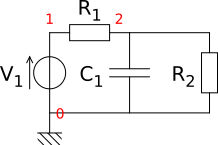

In [1]:
from IPython.display import Image
Image(filename='/home/vince/CloudStation/R&D/SPICE/01_Lecture_Spice_Python/figureB.png')

Le fichier ci-dessous décrit ce circuit et fait une analyse AC (réponse fréquentielle). Les données exportées sont la tension en décibel et la phase sur le noeud 2.

circuitRC-1.cir

Circuit RC
v1 1 0 dc 0 ac 1
r1 1 2 1k 
c1 2 0 100n
r2 2 0 1MEG
.control
ac dec 10 10Hz 100kHz
print vdb(2) vp(2)> export-1.txt
.endc
.end
            

Voici la commande exécutée :

ngspice -b circuitRC-1.cir

et l'importation des données dans python :

                                   circuit rc

                                   AC Analysis  Mon Dec 11 22:05:30  2017

['Index', 'frequency', 'vdb(2)', 'vp(2)']


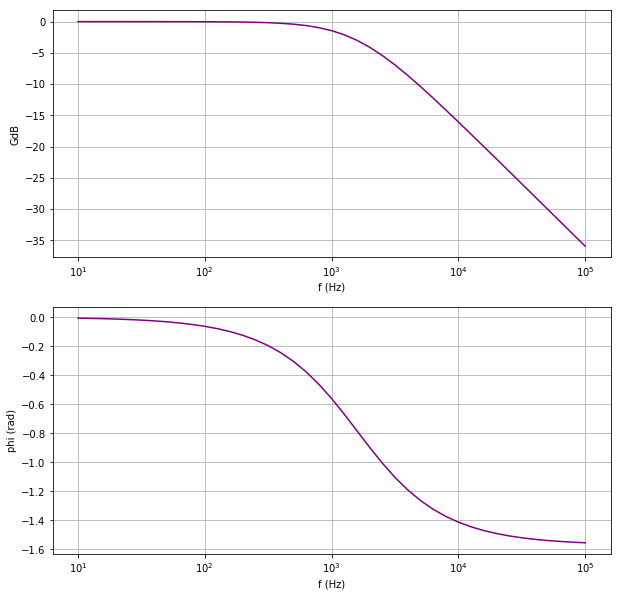

In [6]:
from lectureSpicePrint import lectureSpicePrint
from matplotlib.pyplot import *
% matplotlib inline
data = lectureSpicePrint("export-1.txt")
f = data["frequency"]
vdb2 = data["vdb(2)"]
vp2 = data["vp(2)"]
figure(figsize=(10,10))
subplot("211")
plot(f,vdb2,'purple')
xscale('symlog')
xlabel('f (Hz)')
ylabel('GdB')
grid()
subplot("212")
plot(f,vp2,'purple')
xscale('symlog')
xlabel('f (Hz)')
ylabel('phi (rad)')
grid()

Faisons une analyse transitoire avec le même circuit :

circuitRC-2.cir

Circuit RC
v1 1 0 dc 1
r1 1 2 1k 
c1 2 0 100n ic=0
r2 2 0 1MEG
.control
tran 1Us 1ms uic
print v(2)> export-2.txt
.endc
.end
            

ngspice -b circuitRC-2.cir

                                   circuit rc

                                   Transient Analysis  Mon Dec 11 22:14:33  2017

['Index', 'time', 'v(2)']


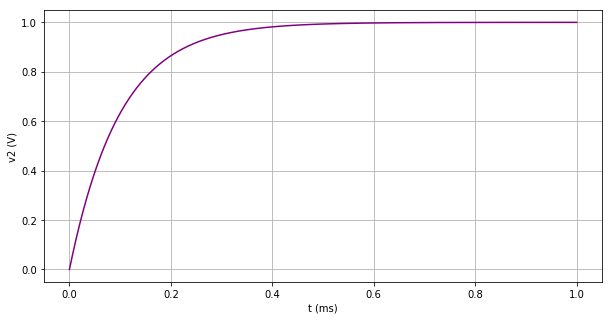

In [5]:
data = lectureSpicePrint("export-2.txt")
t = data["time"]*1000
v2 = data["v(2)"]
figure(figsize=(10,5))
plot(t,v2,'purple')
xlabel("t (ms)")
ylabel("v2 (V)")
grid()